---
# **Unsupervised Semantic Sentiment Analysis of IMDB Reviews**

<a id='Table_of_content'></a>
# Table of contents 
  
1. [Data Preprocessing](#Preprocessing)
  >- Utility module
  
2. [Unsupervised Approach](#Unsupervised_Approach)
 >- Training the word embedding model
 >- Defining the negative and positive sets
 >- Calculating the semantic sentiment of the reviews
 >- High confidence predictions
 
3. [Further Analysis](#Further_Analysis)
 >- Sentiment complexity 
 >- A Qualitative Assessment
 >- Now it's your turn!

<a id='Importing_Librares'></a>

## Importing necessary libraries

In [1]:
# data processing and Data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing

import sklearn
from sklearn.model_selection import train_test_split
    
# Libraries and packages for NLP
import nltk
import gensim
from gensim.models import Word2Vec

# Visualization 
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['figure.figsize'] = (12, 10)
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
print('*** --> Modules are imported: ')    
print("Python version:", sys.version)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

print("sklearn version:", sklearn.__version__)
print("nltk version:", nltk.__version__)
print("gensim version:", gensim.__version__)

*** --> Modules are imported: 
Python version: 3.6.13 (default, Dec 12 2021, 15:04:37) 
[GCC Apple LLVM 13.0.0 (clang-1300.0.29.3)]
numpy version: 1.19.5
pandas version: 1.1.5
sklearn version: 0.24.2
nltk version: 3.6.5
gensim version: 4.1.2


In [4]:
# Importing IMDB Data from data directory which is two directory uper than the current directory
data_path = os.path.abspath(os.path.join(os.pardir, 
                                         os.pardir, 
                                         'data/movie_data.csv'))
df = pd.read_csv(data_path)

df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [3]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

---
[Back to top ^](#Table_of_content)
<a id='Preprocessing'></a>
# 1. Data Preprocessing
---

## Utility module
The [`w2v_utils`](https://github.com/TextualData/IMDB-Semantic-Sentiment-Analysis/blob/main/Word2Vec/src/w2v_utils.py) module contains all general utility functions and classes used in multiple places throughout the post. Here is a list of functions and classes imported from [Word2Vec/src/w2v_utils](https://github.com/TextualData/IMDB-Semantic-Sentiment-Analysis/blob/main/Word2Vec/src/w2v_utils.py):
- `Tokenizer` is a class to clean, de-noise and tokenize the text.
- `evaluate_model` calculates F1, Accuracy, Recall, and Precision Score.
- `bow_vectorizer` converts a list of tokenized text documents to a matrix of token counts (a Bog-of-Words sparse matrix).
- `train_logistic_regressor` builds a LogisticRegressionCV Classifier Model.
- `w2v_trainer` trains a Word2Vec model with tokenized documents and returns keyed vectors and keyed vocabs.
- `calculate_overall_similarity_score` computes vector similarity between doc_tokens and target_tokens as two lists and then returns the semantic similarity scores.
- `overall_semantic_sentiment_analysis` calculates the semantic sentiment of the text. It first computes a  vector for the text (average of the  wordvectors building the text document vector) and two vectors representing our given positive and negative lists of words and then calculates Positive and Negative Sentiment Scores as cosine similarity between the text vector and the positive and negative vectors respectively.
- `list_similarity` calculates vector similarity between two lists of tokens.
- `calculate_topn_similarity_score` defines the similarity of a single word to a document, as the average of its similarity with the top_n most similar words in that document. To calculate the similarity score it calculates the similarity of every word in the target_tokens set with all the words in the doc_tokens, and keeps the top_n highest scores for each word and then averages over all the kept scores.
- `topn_semantic_sentiment_analysis` calculates the semantic sentiment of an list of tokenized text documents by using `calculate_topn_similarity_score` function. 
- `define_complexity_subjectivity_reviews` defines high sentiment complexity reviews and Low Subjectivity reviews in a slice of dataset.
- `explore_high_complexity_reviews` plots the distribution of high complexity reviews on the PSS-NSS plane, and reveals the reviews' text by hovering over the points. 
- `explore_low_subjectivity_reviews` plots the distribution of low subjectivity reviews on the PSS-NSS plane, and reveals the reviews' text by hovering over the points. 
- `text_SSA` gets a text as input and then processes it and analyzes its Semantic Sentiment by `topn_semantic_sentiment_analysis` function. 

In [4]:
# Adding `src` directory to the directories for interpreter to search
sys.path.append(os.path.abspath(os.path.join('../..','Word2Vec/src')))

# Importing functions and classes from utility module
from w2v_utils import (Tokenizer,
                       evaluate_model,
                       bow_vectorizer,
                       train_logistic_regressor,
                       w2v_trainer,
                       calculate_overall_similarity_score,
                       overall_semantic_sentiment_analysis,
                       list_similarity,
                       calculate_topn_similarity_score,
                       topn_semantic_sentiment_analysis,
                       define_complexity_subjectivity_reviews,
                       explore_high_complexity_reviews,
                       explore_low_subjectivity_reviews,
                       text_SSA)

The `Tokenizer` class will handle all tokenization tasks and enable us to play with different tokeniztion options. This class has the following boolean attributes: `clean`, `lower`, `de_noise`, `remove_stop_words`, and `keep_neagation`. All attributes default to `True`, but you can change them to see the effect of different text preprosessing options. By default, this class denoises the text (removing HTML and URL components), convert the text into lowercase, clean the text from all non-alphanumeric characters, and remove stop-words. A nuance here is negation stopwords such as "not" and "no". Negation words are considered as *sentiment shifter* as they often change sentiment of the sentence in the opposite directions (For more on "Negation and Sentiment" see Bing Liu, *Sentiment Analysis: Mining Opinions, Sentiments, and Emotions*, Cambridge University Press 2015, pp. 116-122). If `keep_neagation` is True, the tokenizer will attach the negation tokens to the next token and treat them as a single word before removing the stopwords. For the models we are using in this post, we don't need to break our reviews into sentences, and the whole review is tokenized at once. Now, let's instantiate the tokenizer and test it on an example. 

In [5]:
# Instancing the Tokenizer class
tokenizer = Tokenizer(clean= True,
                      lower= True, 
                      de_noise= True, 
                      remove_stop_words= True,
                      keep_negation=True)

# Example statement
statement = "I didn't like this movie. It wasn't amusing nor visually interesting . I do not recommend it."
print(tokenizer.tokenize(statement))

['NOTlike', 'movie', 'NOTamusing', 'visually', 'interesting', 'NOTrecommend']


Now we can tokenize all the reviews and quickly look at some statistics about the review length. 

In [6]:
# Tokenize reviews
df['tokenized_text'] = df['review'].apply(tokenizer.tokenize)

df['tokenized_text_len'] = df['tokenized_text'].apply(len)
df['tokenized_text_len'].apply(np.log).describe()

count    50000.000000
mean         4.571454
std          0.651986
min          1.098612
25%          4.158883
50%          4.499810
75%          4.983607
max          7.270313
Name: tokenized_text_len, dtype: float64

And finally we break the data into train and test before going further.

In [7]:
# Separating the target
y = df['sentiment'] 
X = df.drop(columns=['sentiment']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.3,
                                                    stratify=y)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (35000, 3)
X_test shape:  (15000, 3)


---
[Back to top ^](#Table_of_content)
<a id='Unsupervised_Approach'></a> 
# 2. Unsupervised Approach
---
After working out the basics, we can now move on to the gist of this post, namely the unsupervised approach to sentiment analysis, which I call Semantic Similarity Analysis (SSA) from now on. In this approach, I first train a word embedding model using all the reviews. The characteristics of this embedding space is that the similarity between words in this space (Cosine similarity here) is a measure of their semantic relevance. Next I will choose two sets of words that are carrying positive and negative sentiments in the context in which we are working. Now in order to predict the sentiment of a review, we will calculate its similarity in the word embedding space to these positive and negative sets and see which sentiment the text is closest to.

## Training the word embedding model
Before going into further details, let's train the word embedding model. [Published in 2013 by Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf), the introduction of word embedding was a game-changer advancement in NLP. This approach is sometimes called word2vec as the model converts words into vectors in an embedding space. I use gensim package to train the wordd2vec model. Since we don't need to split our dataset into train and test for building unsupervised models, I train the model on the whole data. I also set the embedding dimension to be 300.

In [10]:
%%time
# Training a Word2Vec model
keyed_vectors, keyed_vocab = w2v_trainer(df['tokenized_text'],
                                               epochs=10,
                                               workers=3,
                                               vector_size=300,
                                               window=5,
                                               min_count=2)

CPU times: user 3min 2s, sys: 800 ms, total: 3min 2s
Wall time: 1min 2s


## Defining the negative and positive sets
There is no unique formula to choose the positive and negative set. However, in order to have a starting point, I checked the most similar words to the words 'good' and 'bad' in our newly trained embedding space. Mixing it with my judgement on the context, I came up with the following lists:

- `positive_concepts` = ['excellent', 'awesome', 'cool', 'decent', 'amazing', 'strong', 'good', 'great', 'funny', 'entertaining'] 
- `negative_concepts` = ['terrible', 'awful', 'horrible', 'boring', 'bad', 'disappointing', 'weak', 'poor',  'senseless', 'confusing']

Please note that we should make sure that all `positive_concepts` and `negative_concepts` are represented in our word2vec model. 

In [11]:
# Find the most similar words to "good" based on word vectors from our trained model
keyed_vectors.most_similar('good',topn=15)

[('decent', 0.6242865324020386),
 ('NOTbad', 0.550041675567627),
 ('alright', 0.5251046419143677),
 ('great', 0.5143460631370544),
 ('bad', 0.5134716033935547),
 ('ok', 0.47733184695243835),
 ('acceptable', 0.4728247821331024),
 ('NOTgood', 0.47116589546203613),
 ('nice', 0.4672098457813263),
 ('excellent', 0.4644799530506134),
 ('passable', 0.4644753336906433),
 ('NOTgreat', 0.4635024070739746),
 ('solid', 0.4629504978656769),
 ('lousy', 0.46161243319511414),
 ('competent', 0.4602532684803009)]

In [12]:
# To make sure that all `positive_concepts` are in the keyed word2vec vocabulary
positive_concepts = ['excellent', 'awesome', 'cool','decent','amazing', 'strong', 'good', 'great', 'funny', 'entertaining'] 
pos_concepts = [concept for concept in positive_concepts if concept in keyed_vocab]
len(positive_concepts)

10

In [13]:
# Find the most similar words to "bad" based on word vectors from our trained model
keyed_vectors.most_similar('bad',topn=15)

[('terrible', 0.584291398525238),
 ('awful', 0.5767611861228943),
 ('horrible', 0.5710924863815308),
 ('lousy', 0.5658139586448669),
 ('good', 0.5134715437889099),
 ('sucks', 0.5095511674880981),
 ('atrocious', 0.5095438361167908),
 ('crappy', 0.5030581951141357),
 ('NOTgood', 0.4757572114467621),
 ('cheesy', 0.4754055440425873),
 ('stupid', 0.4733394384384155),
 ('sucked', 0.47197890281677246),
 ('suck', 0.4649698734283447),
 ('lame', 0.4649367332458496),
 ('dreadful', 0.4641149044036865)]

In [14]:
# To make sure that all `negative_concepts` are in the keyed word2vec vocabulary 
negative_concepts = ['terrible','awful','horrible','boring','bad', 'disappointing', 'weak', 'poor',  'senseless','confusing'] 
neg_concepts = [concept for concept in negative_concepts if concept in keyed_vocab]
len(negative_concepts)

10

## Calculating the semantic sentiment of the reviews
As we mentioned earlier, in order to predict the sentiment of a review, we need to calculate its similarity to our negative and positive sets. We will call these similarities negative semantic score (NSS) and positive semantic scores (PSS) respectively. There are several ways to calculate the similarity between two collections of words. One of the most common approaches is to build the document vector by averaging over the wordvectors building it. In that way, we will have a vector for every review and two vectors representing our positive and negative sets. The PSS and NSS can then be calculated by a simple cosine similarity between the review vector and the positive and negative vectors respectively. Let's call this approach *Overall Semantic Sentiment Analysis* (**OSSA**).

However, averaging over all wordvectors in a document is not the best way to build document vectors. Consider a document with 100 words. Most words in that document are so-called glue words that are not contributing to the meaning or sentiment of a document but rather are there to hold the linguistic structure of the text. That means that if we average over all the words, the effect of meaningful words will be reduced by the glue words.

To solve this issue, I define the similarity of a single word to a document, as the average of its similarity with the top_n most similar words in that document. Then I will calculate this similarity for every word in my positive and negative sets and average over to get the positive and negative scores. To put it differently, in order to calculate the positive score for a review, I calculate the similarity of every word in the positive set with all the words in the review, and keep the top_n highest scores for each positive word and then average over all the kept scores. This approach could be called *TopN Semantic Sentiment Analysis* (**TopSSA**).

After calculating the positive and negative scores, we define
    
`semantic_sentiment_score (S3) = positive_sentiment_score (PSS) - negative_sentiment_score (NSS)`

If the S3 is positive, we can classify the review as positive, and if it is negative, we can classify it as negative. Now let's see how such a model performs (The code includes both OSSA and TopSSA approaches, but in this post, only the latter will be explored).


In [15]:
%%time
# Calculating Semantic Sentiment Scores by OSSA model
overall_df_scores = overall_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'])

# Calculating Semantic Sentiment Scores by TopSSA model
topn_df_scores = topn_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'],
                                                     topn=30)



# To store semantic sentiment store computed by OSSA model in df
df['overall_PSS'] = overall_df_scores[0] 
df['overall_NSS'] = overall_df_scores[1] 
df['overall_semantic_sentiment_score'] = overall_df_scores[2] 
df['overall_semantic_sentiment_polarity'] = overall_df_scores[3]



# To store semantic sentiment store computed by TopSSA model in df
df['topn_PSS'] = topn_df_scores[0] 
df['topn_NSS'] = topn_df_scores[1] 
df['topn_semantic_sentiment_score'] = topn_df_scores[2] 
df['topn_semantic_sentiment_polarity'] = topn_df_scores[3]


CPU times: user 5min 29s, sys: 45.8 s, total: 6min 15s
Wall time: 1min 30s


              precision    recall  f1-score   support

           0     0.9078    0.8913    0.8995      7500
           1     0.8933    0.9095    0.9013      7500

    accuracy                         0.9004     15000
   macro avg     0.9005    0.9004    0.9004     15000
weighted avg     0.9005    0.9004    0.9004     15000



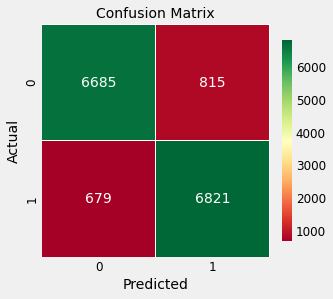

In [9]:
y_predict_bow_lr = bow_logistreg_model.predict(X_test_bow_matrix)

evaluate_model(y_true = y_test, 
                         y_pred = y_predict_bow_lr, 
                         report=True,
                         plot=True)

Let's visualize the data to understand the results better. In the below scatter plot each review has been placed on the plane based on its PSS and NSS. Therefore, all points above the decision boundary (diagonal blue line) have positive S3 and are then predicted to have a positive sentiment and all points below the boundary have negative S3 and are thus predicted to have a negative sentiment. The actual sentiment labels of reviews are shown by green (positive) and red (negative). It is evident from the plot that most mislabelings happen close to the decision boundary as expected.  

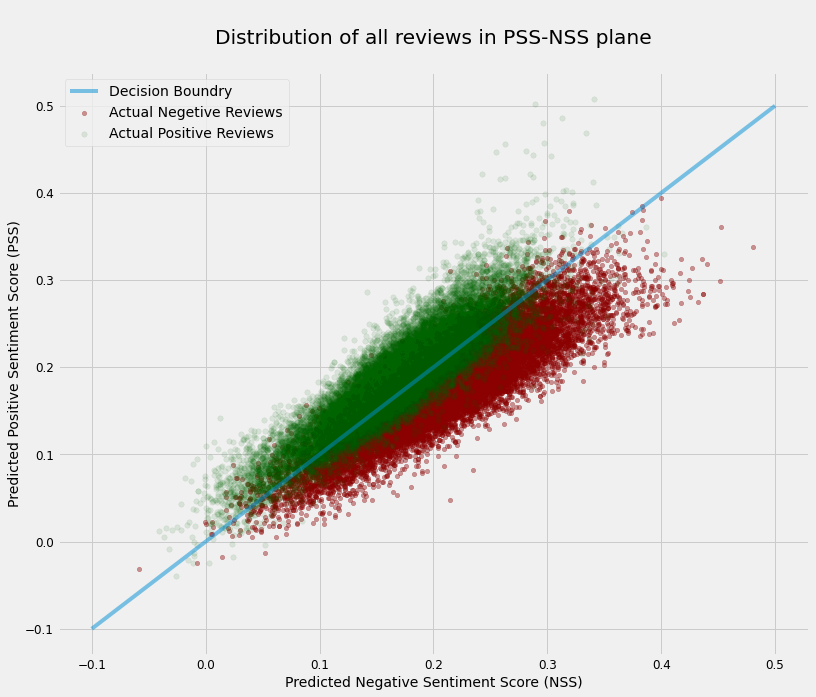

In [17]:
# TopSSA Model
# filter positive and negative review based on Target Variable (actual 'y') or 'sentiment' column
actual_pos_filt = df['sentiment'] == 1
actual_neg_filt =  df['sentiment'] == 0

# filter positive and negative review based on Most Probable predicted 'y' or 'topn_semantic_sentiment_score' column
predicted_pos_filt = df['topn_semantic_sentiment_polarity'] == 1
predicted_neg_filt = df['topn_semantic_sentiment_polarity'] == 0



# plotting Semantic Sentiment Score Position of Actual Negative Reviews 
plt.scatter(df['topn_NSS'][actual_neg_filt], 
         df['topn_PSS'][actual_neg_filt],  
         label='Actual Negetive Reviews',
           color='DarkRed',
            alpha=0.4 , # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of Actual Positive Reviews 
plt.scatter(df['topn_NSS'][actual_pos_filt], 
         df['topn_PSS'][actual_pos_filt],  
         label='Actual Positive Reviews',
       color='DarkGreen',
            alpha=0.1, # set transparency of color
            s=30 # set size of dots
           )
# naming the x & y axis
plt.xlabel('Predicted Negative Sentiment Score (NSS)')
plt.ylabel('Predicted Positive Sentiment Score (PSS)')


# plotting the bisector
plt.plot([-0.1,0.5], 
         [-0.1,0.5], 
         alpha=0.5,
        label='Decision Boundry')

# show a legend on the plot
plt.legend()

# giving a title to the graph
plt.title("""
Distribution of all reviews in PSS-NSS plane
""")

# To save the result in the same folder
plt.savefig('../reports/figures/distribution_of_all_reviews_in_PSS_NSS_plane_TopSSA.png')

plt.show()

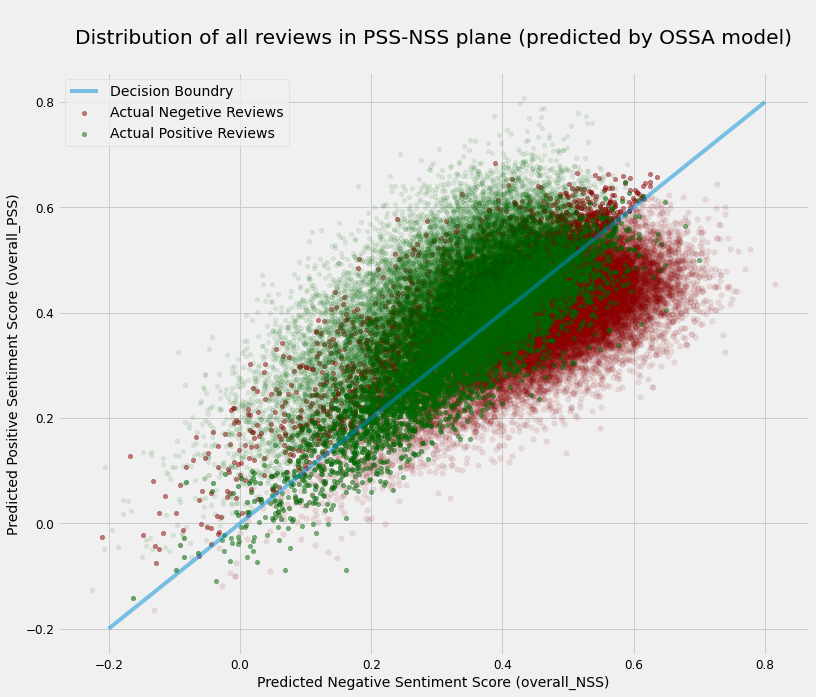

In [18]:

# filter positive and negative review based on Most Probable predicted 'y' or 'overall_semantic_sentiment_score' column
overall_predicted_pos_filt = df['overall_semantic_sentiment_polarity'] == 1
overall_predicted_neg_filt = df['overall_semantic_sentiment_polarity'] == 0

# OSSA Model
# plotting Semantic Sentiment Score Position of Predicted Positive Reviews 
## Predicted Positive but Actual Negative with less transparent red
plt.scatter(df['overall_NSS'][overall_predicted_pos_filt][actual_neg_filt], 
         df['overall_PSS'][overall_predicted_pos_filt][actual_neg_filt],  
         label='Actual Negetive Reviews',
           color='DarkRed',
            alpha=0.5 , # set transparency of color
            s=20 # set size of dots
           )
## Predicted Positive & Actual Positive with more transparent green
plt.scatter(df['overall_NSS'][overall_predicted_pos_filt][actual_pos_filt], 
         df['overall_PSS'][overall_predicted_pos_filt][actual_pos_filt],  
           color='DarkGreen',
            alpha=0.1 , # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of  Predicted Negative Reviews 
## Predicted Negative & Actual Negative with more transparent red
plt.scatter(df['overall_NSS'][overall_predicted_neg_filt][actual_neg_filt], 
         df['overall_PSS'][overall_predicted_neg_filt][actual_neg_filt],  
       color='DarkRed',
            alpha=0.1, # set transparency of color
            s=30 # set size of dots
           )
# Predicted Negative but Actual Positive with less transparent green
plt.scatter(df['overall_NSS'][predicted_neg_filt][actual_pos_filt], 
         df['overall_PSS'][predicted_neg_filt][actual_pos_filt],  
         label='Actual Positive Reviews',
           color='DarkGreen',
            alpha=0.5 , # set transparency of color
            s=20 # set size of dots
           )

# naming the x & y axis
plt.xlabel('Predicted Negative Sentiment Score (overall_NSS)')
plt.ylabel('Predicted Positive Sentiment Score (overall_PSS)')


# plotting the bisector
plt.plot([-0.2,0.8], 
         [-0.2,0.8], 
         alpha=0.5,
         label='Decision Boundry')

# show a legend on the plot
plt.legend()

# giving a title to the graph
plt.title("""
Distribution of all reviews in PSS-NSS plane (predicted by OSSA model)
""")

# To save the result in the same folder
plt.savefig('../reports/figures/distribution_of_all_reviews_in_PSS_NSS_plane_OSSA.png')

plt.show()

## High confidence predictions
It is well-known that the results further from the decision boundary have better performance. Here I show that this applies to our unsupervised model as well. To do so, I plotted the distribution of the S3, PSS, and NSS for all reviews. As we would expect from Central Limit Theorem, all three distributions are very close to normal with S3 having a mean and std of -0.003918 and 0.037186 respectively. Next, I define the high confidence predictions to be those that their S3 is at least `0.5*std` away from the mean. That consists of ~64% of reviews and the model has the F1 of ~94% for them. 

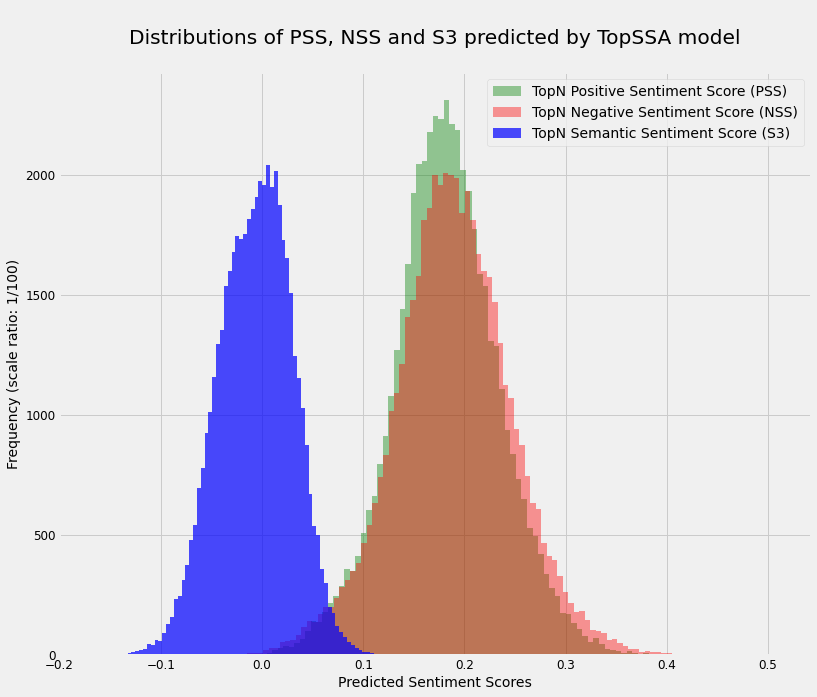

In [19]:
# Plotting Distributions of the PSS, NSS, and S3 Predicted by TopSSA Model
plt.hist(df['topn_PSS'],
        bins=100, color='green', alpha=0.4,
        label= 'TopN Positive Sentiment Score (PSS)')

plt.hist(df['topn_NSS'],
        bins=100, color='red', alpha=0.4,
        label= 'TopN Negative Sentiment Score (NSS)')

plt.hist(df['topn_semantic_sentiment_score'],
        bins=100, color='blue', alpha=0.7,
        label= 'TopN Semantic Sentiment Score (S3)')

# naming the x & y axis
plt.xlabel('Predicted Sentiment Scores')
plt.ylabel('Frequency (scale ratio: 1/100)')

# show a legend on the plot
plt.legend()

plt.title("""
Distributions of PSS, NSS and S3 predicted by TopSSA model
""")

# To save the result in the same folder
plt.savefig('../reports/figures/pss_nss_s3_Distributions.png')

plt.show()

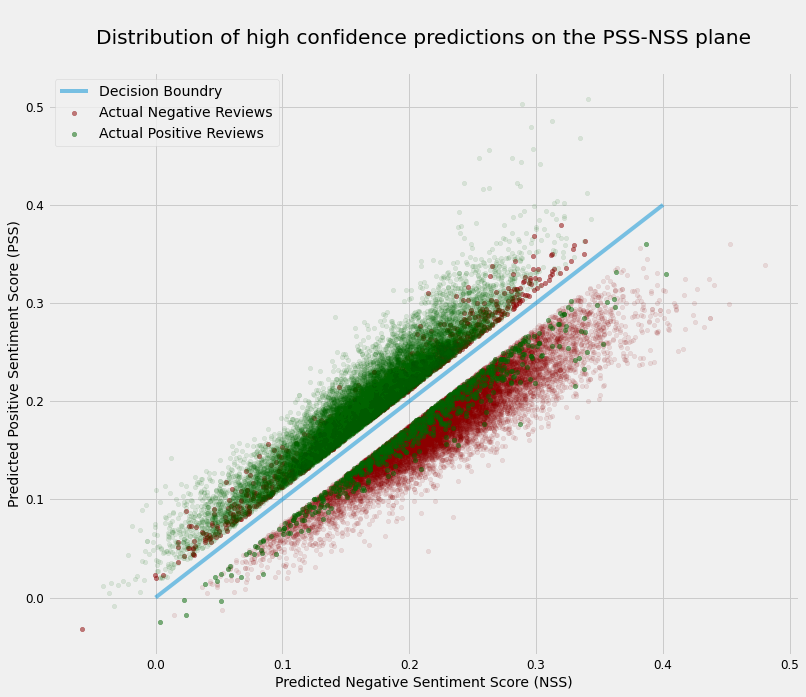

Evaluation Metrics of TopSSA model on the most probable data: 

              precision    recall  f1-score   support

           0     0.9507    0.9242    0.9373     16079
           1     0.9255    0.9516    0.9384     15907

    accuracy                         0.9378     31986
   macro avg     0.9381    0.9379    0.9378     31986
weighted avg     0.9382    0.9378    0.9378     31986



In [20]:
# Filtering the most/the less probably true predictions (TopSSA Model)

# std is standard deviation 
S3_std = df['topn_semantic_sentiment_score'].std()
S3_mean = df['topn_semantic_sentiment_score'].mean()

most_probable_predicted_pos_filt = df['topn_semantic_sentiment_score'] >= (S3_mean + 0.5*S3_std)
most_probable_predicted_neg_filt = df['topn_semantic_sentiment_score'] <= (S3_mean - 0.5*S3_std)

# to create the most probable dataframe:
df_most_probable = pd.concat([df[most_probable_predicted_pos_filt], 
                              df[most_probable_predicted_neg_filt]], axis=0)

# plotting Semantic Sentiment Score Position of Most Probable Predicted Positive:
# Predicted Positive but Actual Negative
plt.scatter(df['topn_NSS'][most_probable_predicted_pos_filt][actual_neg_filt], 
         df['topn_PSS'][most_probable_predicted_pos_filt][actual_neg_filt],  
         label='Actual Negative Reviews',
       color='DarkRed',
            alpha=0.5, # set transparency of color
            s=20 # set size of dots
           )

# Predicted Positive & Actual Positive 
plt.scatter(df['topn_NSS'][most_probable_predicted_pos_filt][actual_pos_filt], 
         df['topn_PSS'][most_probable_predicted_pos_filt][actual_pos_filt],  
       color='DarkGreen',
            alpha=0.1, # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of Most Probable Predicted Negative Reviews
# Predicted Negative & Actual Negative
plt.scatter(df['topn_NSS'][most_probable_predicted_neg_filt][actual_neg_filt], 
         df['topn_PSS'][most_probable_predicted_neg_filt][actual_neg_filt],  
       color='DarkRed',
            alpha=0.1, # set transparency of color
            s=20 # set size of dots
           )

# Predicted Negative but Actual Positive 
plt.scatter(df['topn_NSS'][most_probable_predicted_neg_filt][actual_pos_filt], 
         df['topn_PSS'][most_probable_predicted_neg_filt][actual_pos_filt],
            label='Actual Positive Reviews',
       color='DarkGreen',
            alpha=0.5, # set transparency of color
            s=20 # set size of dots
           )
# naming the x & y axis
plt.xlabel('Predicted Negative Sentiment Score (NSS)')
plt.ylabel('Predicted Positive Sentiment Score (PSS)')

# plotting the bisector
plt.plot([0,0.4],
         [0,0.4], 
         alpha=0.5,
         label='Decision Boundry')

# show a legend on the plot
plt.legend()

# giving a title to the graph
plt.title("""
Distribution of high confidence predictions on the PSS-NSS plane
""")

# To save the result in the same folder
plt.savefig('../reports/figures/distribution_of_high_confidence_predictions_on_PSS_NSS_plane.png')

plt.show()

# Evaluation Metrics 
print('Evaluation Metrics of TopSSA model on the most probable data: \n')
evaluate_model(df_most_probable['sentiment'], 
                         df_most_probable['topn_semantic_sentiment_polarity'],
                        report=True)

---
[Back to top ^](#Table_of_content)

<a id='Further_Analysis'></a> 
# 5. Further Analysis
---

So far, I showed how a simple unsupervised model can perform very well on a sentiment analysis task. As I promised in the introduction, now I will show how this model will be able to provide additional valuable information that supervised models are not providing. Namely, I will show that this model can give us an understanding of the sentiment complexity of the text. To do so, I will again rely on our positive and negative scores. First, let's look into another property of those scores. In addition to the fact that both scores are normally distributed, their values are correlated with the length of the review. Namely, the longer the review, the higher its negative and positive scores. A simple explanation is that with more words, one can potentially express more positive or negative emotions. Of course, the scores cannot be more than 1 and they saturate eventually (around 0.35 here). The below plot shows the correlation very well. Please note that in order to better depict this for both PSS and NSS, I reversed the sign of NSS values.

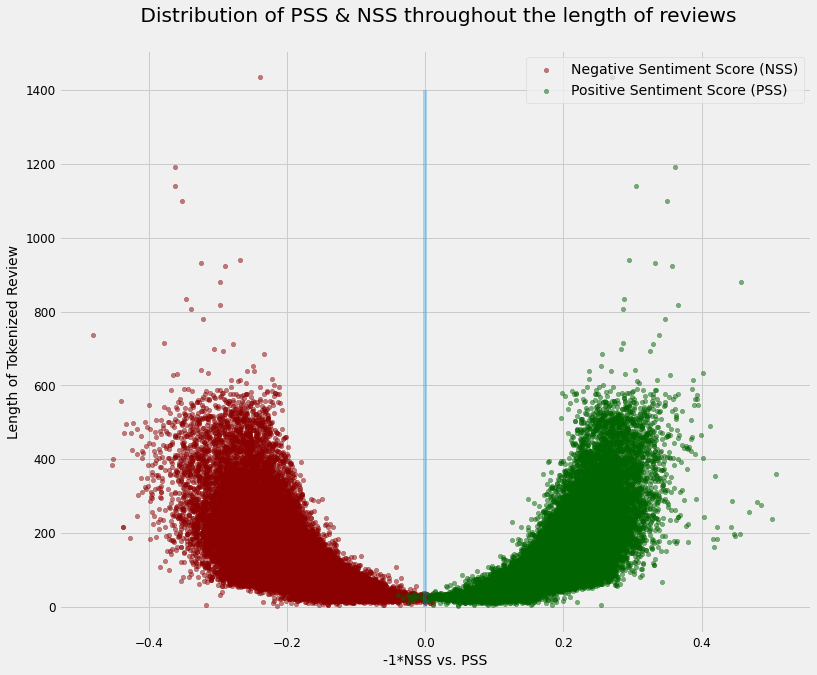

In [21]:
# To plot the relationship between length of review and its Semantic Sentiment Score
# to plot Negative Score Position of all Reviews
plt.scatter(-df['topn_NSS'], 
            df['tokenized_text_len'],
            label='Negative Sentiment Score (NSS)',
            color='DarkRed',
            alpha=0.5, # set transparency of color
            s=20 # set size of dots
           )

# to plot Positive Score Position of all Reviews
plt.scatter(df['topn_PSS'], 
            df['tokenized_text_len'],  
            label='Positive Sentiment Score (PSS)',
            color='DarkGreen',
            alpha=0.5, # set transparency of color
            s=20 # set size of dots
           )

# naming the x & y axis
plt.xlabel('-1*NSS vs. PSS')
plt.ylabel('Length of Tokenized Review')

# plotting the bisector
plt.plot([0,0], [0,1400], alpha=0.3) 

# show a legend on the plot
plt.legend()

# giving a title to the graph
plt.title(""" Distribution of PSS & NSS throughout the length of reviews
""")

# To save the result in the same folder
plt.savefig('../reports/figures/pss_nss_distribution_throughout_length.png')


plt.show()


Therefore to account for the effect of text length in our analysis, we slice the dataset so that reviews placed in each subset would be close in length. In this post, I limit the analysis to the reviews between 100 to 140 tokens (the average number of tokens in reviews is 120). This slice has around 8400 datapoints in it and their respective F1 score is ~82%, which is close to the F1 score on the whole dataset. Additionally, both PSS and NSS in this slice have a normal distribution with the following values:

> PSS_mean = 0.200648  
> PSS_std = 0.031200

> NSS_mean = 0.205617  
> NSS_std = 0.039358 

From now on, any mention of mean and std of PSS and NSS refers to the values in this slice of the dataset.

In [22]:
df_slice = df[df["tokenized_text_len"].between(100,140)]
len(df_slice)

8401

In [23]:
evaluate_model(df_slice["sentiment"] , 
                         df_slice["topn_semantic_sentiment_polarity"],
                        report=True)

              precision    recall  f1-score   support

           0     0.8013    0.8809    0.8392      4332
           1     0.8582    0.7675    0.8103      4069

    accuracy                         0.8260      8401
   macro avg     0.8298    0.8242    0.8248      8401
weighted avg     0.8289    0.8260    0.8252      8401

